In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import pickle

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

keras version  2.4.3


In [3]:
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 100

In [4]:
#Load the data

kv_c_filename = "MouvementData-V1-Courir-Ratti.csv"
ax_c_filename = "MouvementData-V2-Courir-Axel.csv"
ag_c_filename = "MouvementData-V3-Courir-Agigi.csv"
la_c_filename = "MouvementData-V4-Courir-Lavy.csv"
kv_m_filename = "MouvementData-V1-Marche-Ratti.csv"
ax_m_filename = "MouvementData-V4-Marcher-Axel.csv"
ag_m_filename = "MouvementData-V3-Marcher-Agigi.csv"
la_m_filename = "MouvementData-V2-Marcher-Lavy.csv"
kv_i_filename = "MouvementData-V1-Immobile-Ratti.csv"
kv_m2_filename = "MouvementData-V5-Marcher-Ratti.csv"
kv_c2_filename = "MouvementData-V5-Courir-Ratti.csv"

files = {ax_c_filename, ag_c_filename, la_c_filename, kv_m_filename, ax_m_filename, ag_m_filename, la_m_filename, kv_i_filename, kv_m2_filename,kv_c2_filename }
data = pd.read_csv(kv_c_filename, delimiter=",")
for f in files:
    newData = pd.read_csv(f, delimiter=",")
    newData = newData[newData.time >= 100]
    newData = newData[newData.time <= (newData['time'].max() - 300)]
    data = data.append(newData,False,False,False)

data

,userId,dX-acc,dY-acc,dZ-acc,dX-gyr,dY-gyr,dZ-gyr,time,activityType
0,1,0.0,0.0,0.0,0.0,0.0,-0.0,320.0,Courir
1,1,-2.1,9.4,-0.9,0.0,0.0,-0.0,340.0,Courir
2,1,-2.1,9.4,-0.9,0.0,0.0,-0.0,340.0,Courir
3,1,-2.1,9.4,-0.9,0.0,0.0,0.0,500.0,Courir
4,1,-2.1,9.4,-0.9,0.0,0.0,0.0,542.0,Courir
...,...,...,...,...,...,...,...,...,...
3117,4,-0.6,10.2,0.9,-0.1,-0.5,0.0,56542.0,Courir
3118,4,0.4,9.6,0.9,-0.1,-0.5,0.0,56542.0,Courir
3119,4,0.4,9.6,0.9,-0.3,0.0,0.3,56556.0,Courir
3120,4,0.4,9.6,0.9,0.1,0.2,-0.1,57797.0,Courir


In [5]:
LABELS = data["activityType"].unique()
LABELS

array(['Courir', 'Marcher', 'Immobile'], dtype=object)

In [6]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [7]:
#Make sure all values are float typed
data["dX-acc"] = data["dX-acc"].apply(convert_to_float)
data["dY-acc"] = data["dY-acc"].apply(convert_to_float)
data["dZ-acc"] = data["dZ-acc"].apply(convert_to_float)
data["dX-gyr"] = data["dX-gyr"].apply(convert_to_float)
data["dY-gyr"] = data["dY-gyr"].apply(convert_to_float)
data["dZ-gyr"] = data["dZ-gyr"].apply(convert_to_float)

In [8]:
#Show data information
print('Number of columns in the dataframe: %i' % (data.shape[1]))
print('Number of rows in the dataframe: %i\n' % (data.shape[0]))

Number of columns in the dataframe: 9
Number of rows in the dataframe: 38961



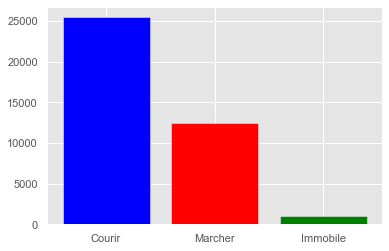

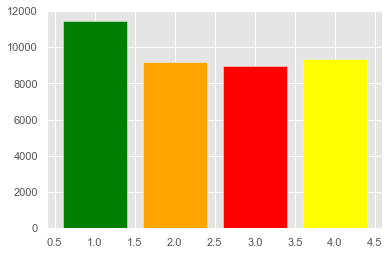

In [9]:
# Show how many training examples exist for each activity
plt.bar(LABELS, data['activityType'].value_counts(), color=['blue', 'red', 'green', 'yellow', 'orange'])
plt.plot(kind='bar',title='Training Examples by Activity Type')
plt.show()
# Show how many training examples exist for each user
USERS = data["userId"].unique()
plt.bar(USERS, data['userId'].value_counts(), color=['green', 'yellow', 'orange', 'red', 'blue'])
plt.plot(kind='bar', title='Training Examples by User')
plt.show()

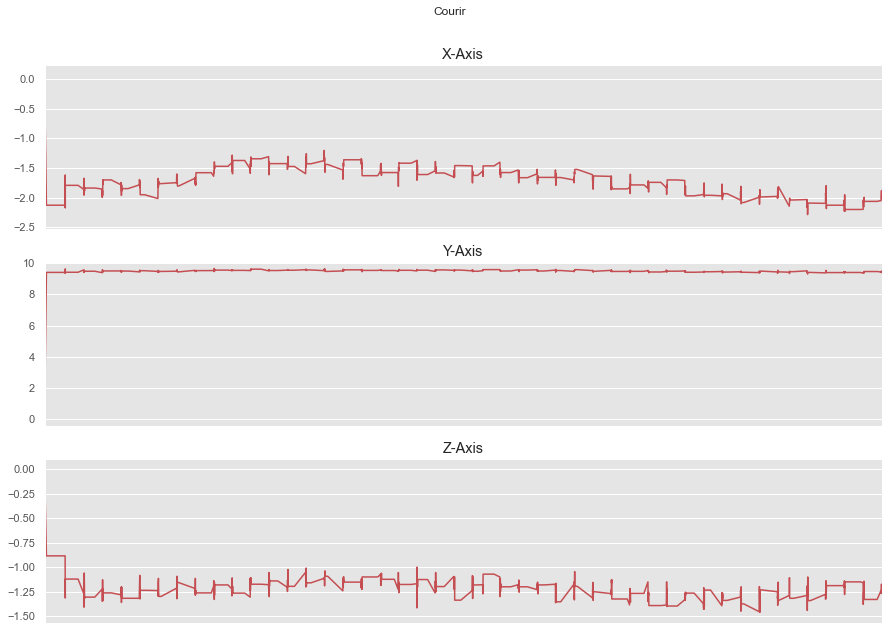

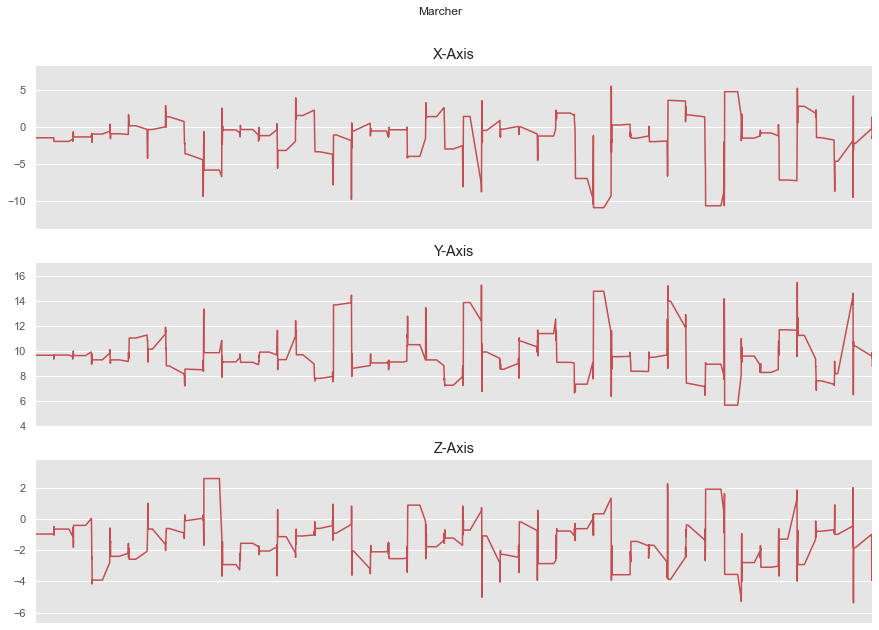

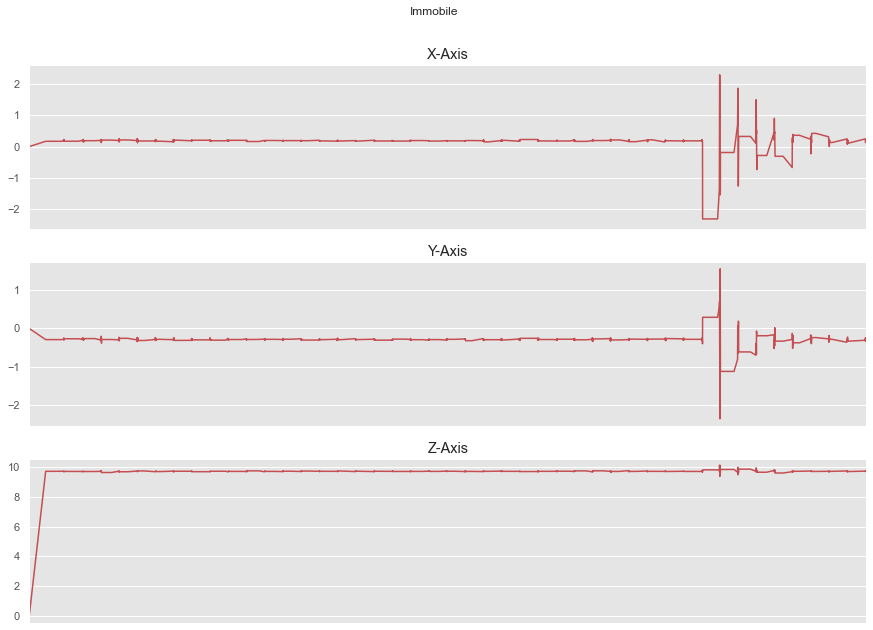

In [10]:
# Sampling frequency = 100Hz

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['time'], data['dX-acc'], 'X-Axis')
    plot_axis(ax1, data['time'], data['dY-acc'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['dZ-acc'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in LABELS:
    #plot the first five seconds (we have a sample every 10ms then 100 per second)
    subset = data[data['activityType'] == activity][:500] 
    plot_activity(activity, subset)

In [11]:
#Transform the labels into numeric values

# Define column name of the label vector
LABEL = 'Numeric activity type'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
data[LABEL] = le.fit_transform(data['activityType'].values.ravel())
print(data['activityType'].unique())
data[LABEL].unique()

['Courir' 'Marcher' 'Immobile']


array([0, 2, 1])

In [12]:
#Split the data using users ID's
#TODO: first, we only have one user Immobile data -> produce another  immobile data
trainingData = data[data["userId"] <= 3]

testData = data[data["userId"] > 3]
#TODO: This will duplicate Immobile data: correct it by adding other Immobile users data
testData = testData.append(data[data["activityType"] == "Immobile"],False,False,False)

In [13]:
#Reshape data into segments and prepare for Keras

def create_segments_and_labels(df, time_steps, step, label_name):

    # dXacc, dYacc, dZacc, dXgyr, dYgyr, dZgyr as features
    N_FEATURES = 6
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        dXaccs = df['dX-acc'].values[i: i + time_steps]
        dYaccs = df['dY-acc'].values[i: i + time_steps]
        dZaccs = df['dZ-acc'].values[i: i + time_steps]
        dXgyrs = df['dX-gyr'].values[i: i + time_steps]
        dYgyrs = df['dY-gyr'].values[i: i + time_steps]
        dZgyrs = df['dZ-gyr'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([dXaccs, dYaccs, dZaccs, dXgyrs, dYgyrs, dZgyrs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [14]:
#Data transformation

def transform_data(data):
    #Normalize training data
    # Normalize features for training data set (values between 0 and 1)
    # Surpress warning for next 3 operation
    pd.options.mode.chained_assignment = None  # default='warn'

    data['dX-acc'] = data['dX-acc'] / data['dX-acc'].max()
    data['dY-acc'] = data['dY-acc'] / data['dY-acc'].max()
    data['dZ-acc'] = data['dZ-acc'] / data['dZ-acc'].max()
    data['dX-gyr'] = data['dX-gyr'] / data['dX-gyr'].max()
    data['dY-gyr'] = data['dY-gyr'] / data['dY-gyr'].max()
    data['dZ-gyr'] = data['dZ-gyr'] / data['dZ-gyr'].max()
    # Round numbers
    data = data.round({'dX-acc': 4, 'dY-acc': 4, 'dZ-acc': 4, 'dX-gyr': 4, 'dY-gyr': 4, 'dZ-gyr': 4 })
    
    x_train, y_train = create_segments_and_labels(data, TIME_PERIODS,STEP_DISTANCE,LABEL)
    
    # Set input & output dimensions
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = le.classes_.size
    
    #Flatten the data for Keras and Core ML. They are not able to deal ith matrixes
    input_shape = (num_time_periods*num_sensors)
    x_train = x_train.reshape(x_train.shape[0], input_shape)
    
    # Convert feature and label data into datatype accepted by Keras
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    
    return x_train, y_train, num_time_periods, num_sensors, num_classes, input_shape

In [15]:
x_train, y_train, num_time_periods, num_sensors, num_classes, input_shape = transform_data(trainingData)

In [16]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (295, 3)


In [17]:
# Create the model

model_m = Sequential()

model_m.add(Reshape((TIME_PERIODS, 6), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 6)            0         
_________________________________________________________________
dense (Dense)                (None, 100, 100)          700       
_________________________________________________________________
dense_1 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 30003     
Total params: 50,903
Trainable params: 50,903
Non-trainable params: 0
____________________________________________________

In [18]:
#Fit the DNN Model in Keras
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 313ms/step - loss: 1.0978 - accuracy: 0.4534 - val_loss: 1.0123 - val_accuracy: 0.8305
Epoch 2/50
1/1 [==============================] - 0s 122ms/step - loss: 1.0037 - accuracy: 0.6441 - val_loss: 0.9413 - val_accuracy: 0.7458
Epoch 3/50
1/1 [==============================] - 0s 95ms/step - loss: 0.9212 - accuracy: 0.7458 - val_loss: 0.8710 - val_accuracy: 0.7119
Epoch 4/50
1/1 [==============================] - 0s 101ms/step - loss: 0.8473 - accuracy: 0.7881 - val_loss: 0.8049 - val_accuracy: 0.7627
Epoch 5/50
1/1 [==============================] - 0s 106ms/step - loss: 0.7858 - accuracy: 0.8263 - val_loss: 0.7435 - val_accuracy: 0.8983
Epoch 6/50
1/1 [==============================] - 0s 83ms/step - loss: 0.7385 - accuracy: 0.8729 - val_loss: 0.6839 - val_accuracy: 0.9831
Epoch 7/50
1/1 [==============================] - 0s 128ms/step - loss: 0.7029 - accuracy: 0.8771 - val_loss: 0.6259 - val_accuracy: 0.9831
Epoch 8/50
1/1 [======

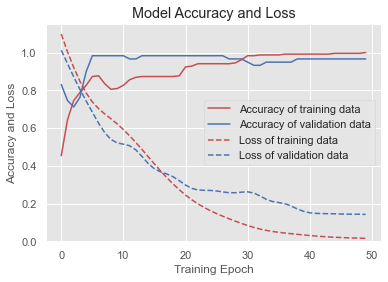

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        94
         1.0       1.00      1.00      1.00        10
         2.0       0.99      0.99      0.99       191

    accuracy                           0.99       295
   macro avg       0.99      0.99      0.99       295
weighted avg       0.99      0.99      0.99       295



In [19]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [20]:
#Prepare and transform test_data
x_test, y_test, num_time_periods, num_sensors, num_classes, input_shape = transform_data(testData)

In [21]:
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_test shape:  (103, 3)


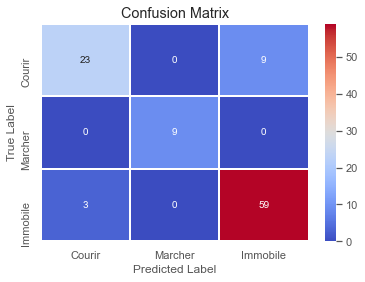

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       1.00      1.00      1.00         9
           2       0.87      0.95      0.91        62

    accuracy                           0.88       103
   macro avg       0.92      0.89      0.90       103
weighted avg       0.88      0.88      0.88       103



In [22]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [23]:
model_m.save('model')